<a href="https://colab.research.google.com/github/Abhishek3009/CerebroSegNet/blob/main/model6_DeeplabV3plus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Deeplab V3+**

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content'

!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

!unzip \*.zip
!rm *.zip

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage import io

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Add
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, UpSampling2D, Reshape, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

from warnings import filterwarnings
filterwarnings('ignore')

import random

from warnings import filterwarnings
filterwarnings('ignore')
import random
from glob import glob
from IPython.display import display

### **Prepare dataset**

### **Load image's path and mask's path**

In [ ]:
#Set Parameters
im_width = 256
im_height = 256
train_files = []
mask_files = glob('/content/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

print(train_files[:10])
print(mask_files[:10])

['/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_54.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_16.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_46.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_17.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_56.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_4.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_14.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_21.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_19.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_5.tif']
['/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_198605

### **Data Visualization**

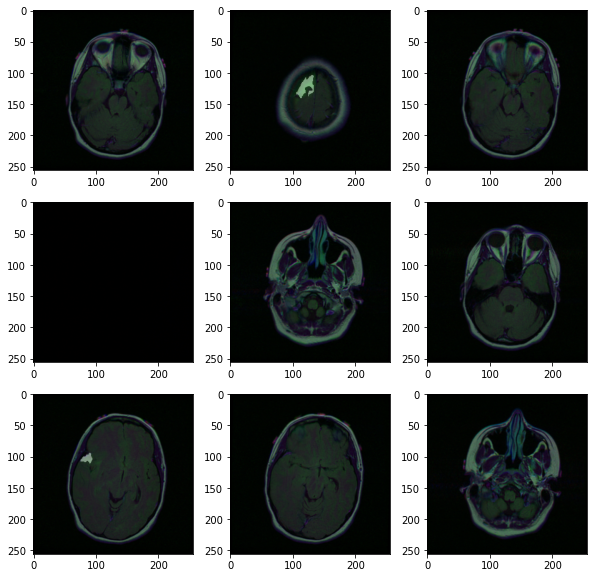

In [ ]:
#Lets plot some samples
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=train_files[i]
    msk_path=mask_files[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
plt.show()

### **Create data frame and split data on train set, validation set and test set**

In [ ]:
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
df_train, df_test = train_test_split(df,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2828, 2)
(708, 2)
(393, 2)


### **Data genertator, data augmentation and adjust data**

In [ ]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return (img, mask)

###**Model**



In [ ]:
def SqueezeAndExcite(inputs, ratio=8):
    init = inputs
    filters = init.shape[-1]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio,
               activation='relu',
               kernel_initializer='he_normal',
               use_bias=False)(se)
    se = Dense(filters,
               activation='sigmoid',
               kernel_initializer='he_normal',
               use_bias=False)(se)
    x = init * se
    return x

In [ ]:
def aspp(inputs):
    shapes = inputs.shape
    y_pool = AveragePooling2D(pool_size=(shapes[1],shapes[2]))(inputs)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization()(y_pool)
    y_pool = Activation("relu")(y_pool)
    y_pool = UpSampling2D((shapes[1],shapes[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(inputs)
    y_1 = BatchNormalization()(y_1)
    y_1 = Activation("relu")(y_1)

    y_6 = Conv2D(filters=256, kernel_size=1, dilation_rate=6, padding='same', kernel_initializer='he_normal', use_bias=False)(inputs)
    y_6 = BatchNormalization()(y_6)
    y_6 = Activation("relu")(y_6)

    y_12 = Conv2D(filters=256, kernel_size=1, dilation_rate=12, padding='same', kernel_initializer='he_normal', use_bias=False)(inputs)
    y_12 = BatchNormalization()(y_12)
    y_12 = Activation("relu")(y_12)

    y_18 = Conv2D(filters=256, kernel_size=1, dilation_rate=18, padding='same', kernel_initializer='he_normal', use_bias=False)(inputs)
    y_18 = BatchNormalization()(y_18)
    y_18 = Activation("relu")(y_18)

    y = Concatenate()([y_pool,y_1, y_6, y_12, y_18])

    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(inputs)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

In [ ]:
def deeplabv3_model(input_shape):
    inputs = Input(input_shape)

    """ Pre-trained ResNet50 """
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    """ Pre-trained ResNet50 Output """
    img_features = base_model.get_layer('conv4_block6_out').output
    x_a = aspp(img_features)
    x_a = UpSampling2D((4,4), interpolation="bilinear")(x_a)

    x_b = base_model.get_layer("conv2_block2_out").output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)

    x = Concatenate()([x_a, x_b])
    x = SqueezeAndExcite(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SqueezeAndExcite(x)

    x = UpSampling2D((4, 4), interpolation="bilinear")(x)
    x = Conv2D(1, 1, kernel_initializer='he_normal')(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs, x)
    return model

In [ ]:
img_height = 256
img_width = 256
num_channels = 3

deeplab = deeplabv3_model((img_height, img_width, num_channels))

In [ ]:
deeplab.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
from tensorflow.keras import backend as K
EPOCHS = 100
BATCH_SIZE = 16
learning_rate = 0.001

In [ ]:
epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

In [ ]:
# compling model and callbacks functions
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
deeplab.compile(optimizer = adam,
                  loss = focal_tversky,
                  metrics = [tversky]
                 )
#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=30
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="/content/Model5_AttentionResUnet_BrainMriSeg.h5",
                               verbose=1,
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

In [ ]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))

val_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))

history = deeplab.fit(train_gen,
                  epochs = EPOCHS,
                  steps_per_epoch=len(df_train) / BATCH_SIZE,
                  validation_data = val_gen,
                  validation_steps=len(df_val) / BATCH_SIZE,
                  callbacks = [checkpointer, earlystopping, reduce_lr])

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/100
177/176 [==============================] - ETA: 0s - loss: 0.6081 - tversky: 0.4649Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 1: val_loss improved from inf to 0.98613, saving model to /content/Model5_AttentionResUnet_BrainMriSeg.h5
176/176 [==============================] - 87s 493ms/step - loss: 0.6081 - tversky: 0.4649 - val_loss: 0.9861 - val_tversky: 0.0182 - lr: 0.0500
Epoch 2/100
177/176 [==============================] - ETA: 0s - loss: 0.3446 - tversky: 0.7520
Epoch 2: val_loss did not improve from 0.98613
176/176 [==============================] - 82s 463ms/step - loss: 0.3446 - tversky: 0.7520 - val_loss: 0.9996 - val_tversky: 5.4819e-04 - lr: 0.0500
Epoch 3/100
177/176 [==============================] - ETA: 0s - loss: 0.4205 - tversky: 0.6753
Epoch 3: val_loss did not improve from 0.98613
176/176 [==============================] - 83s 468ms/step - lo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

deeplab = load_model("/content/Model5_AttentionResUnet_BrainMriSeg.h5",custom_objects={"focal_tversky":focal_tversky,"tversky":tversky,"tversky_loss":tversky_loss})

deeplab.save('/content/drive/MyDrive/Colab Notebooks/Model6_DeeplabV3plus_BrainMriSeg.h5')

Mounted at /content/drive


## Model Evaluation

In [ ]:
history.history.keys()

dict_keys(['loss', 'tversky', 'val_loss', 'val_tversky', 'lr'])

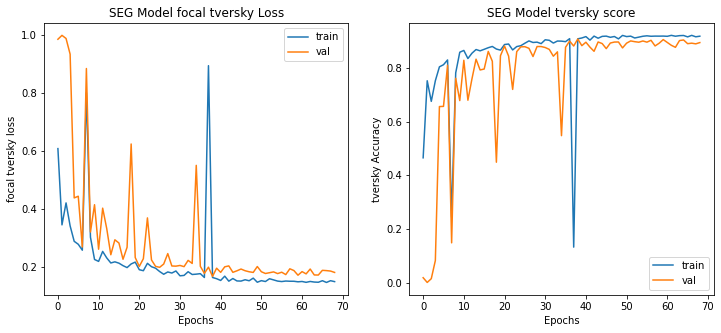

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);
plt.title("SEG Model focal tversky Loss");
plt.ylabel("focal tversky loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(history.history['tversky']);
plt.plot(history.history['val_tversky']);
plt.title("SEG Model tversky score");
plt.ylabel("tversky Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

## Segmantatiın Model Performance

In [ ]:
test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=(im_height, im_width))
results = deeplab.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)

Found 393 validated image filenames.
Found 393 validated image filenames.
24/24 [==============================] - 5s 147ms/step - loss: 0.1956 - tversky: 0.8841


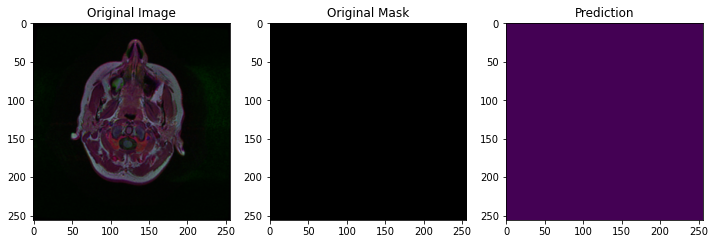

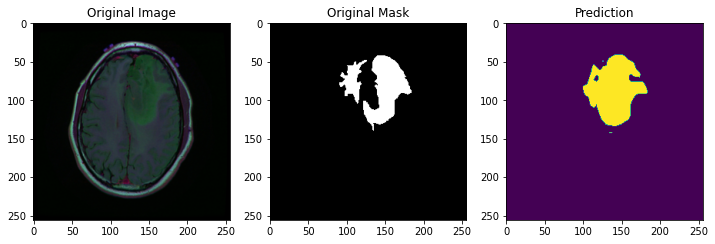

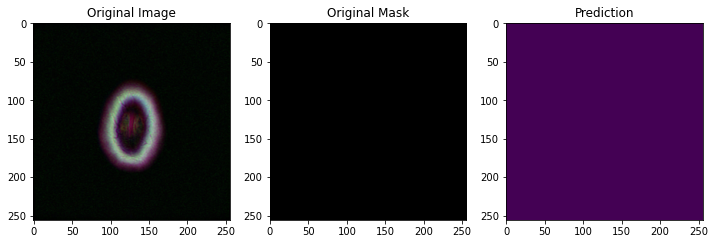

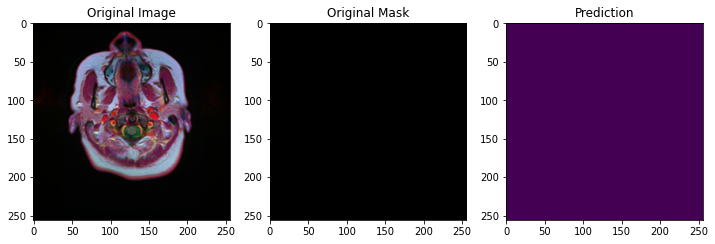

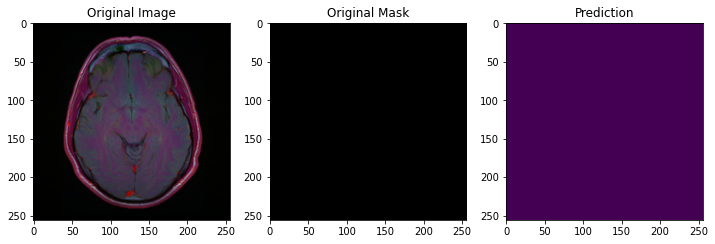

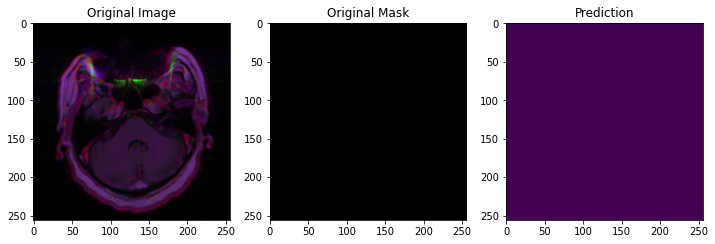

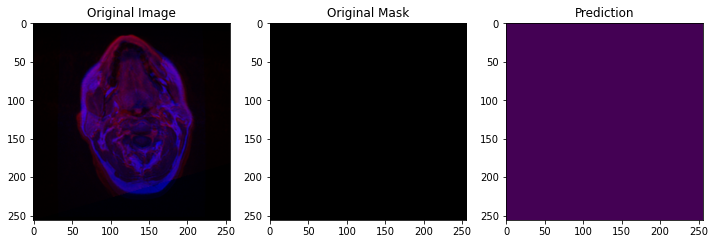

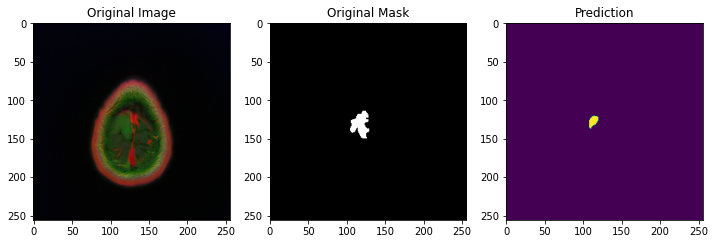

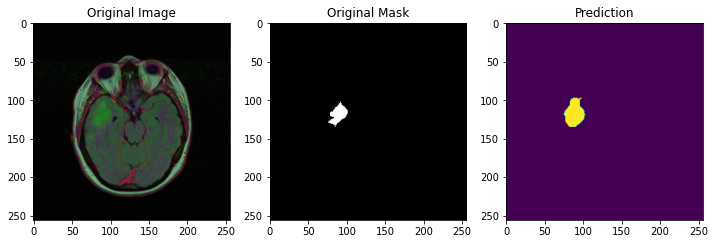

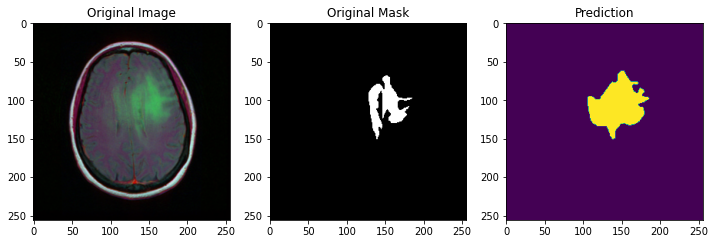

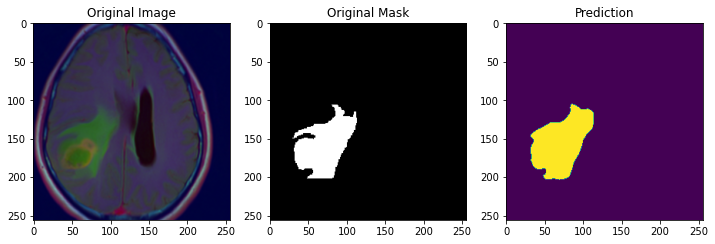

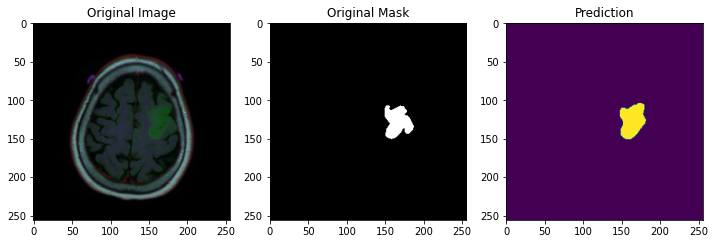

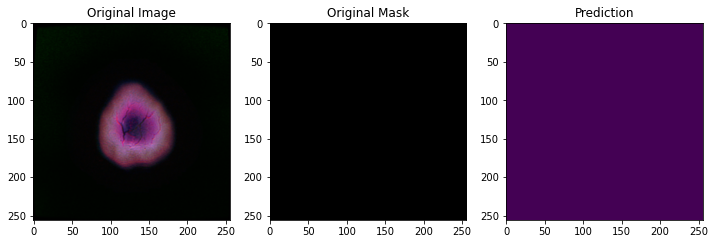

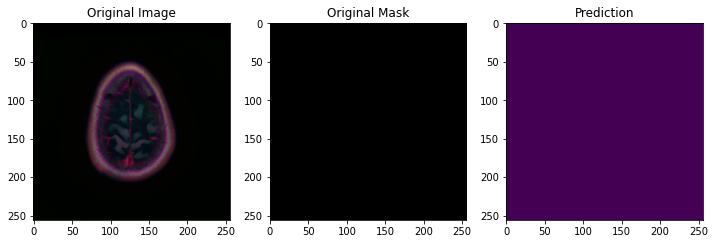

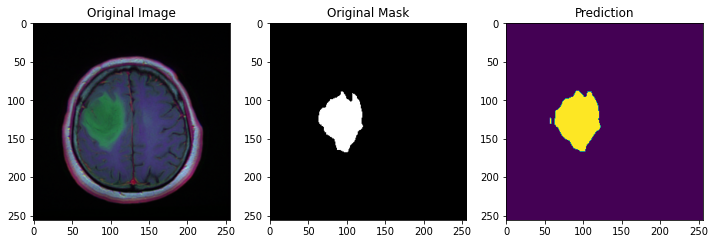

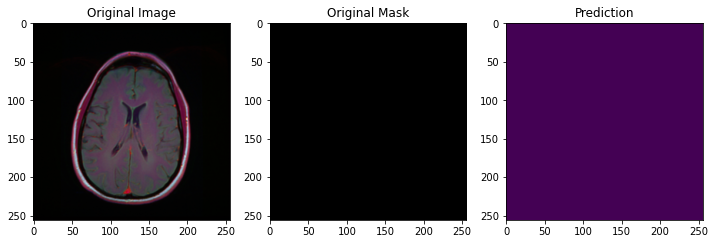

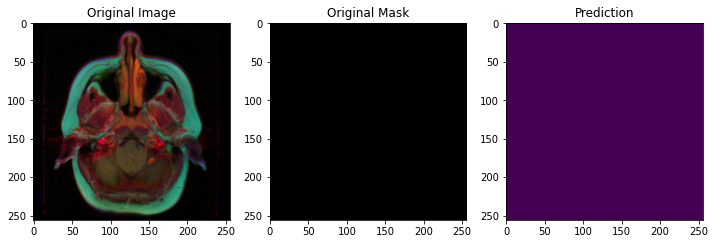

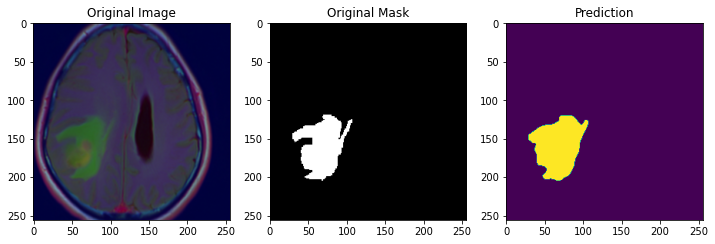

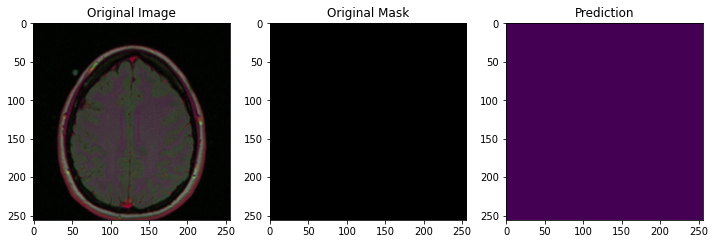

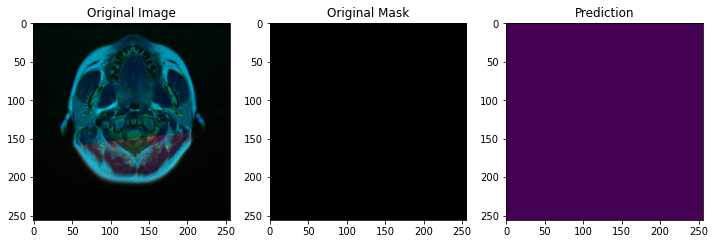

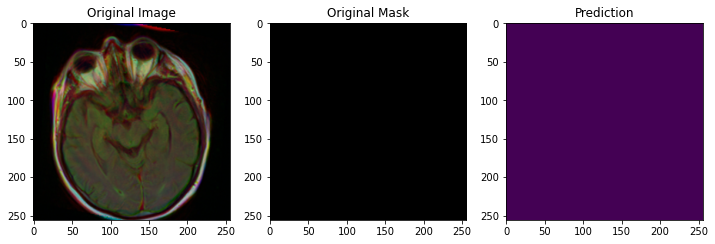

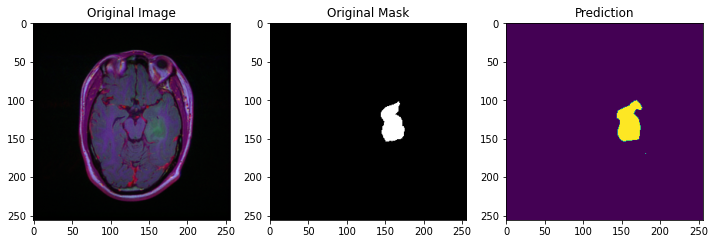

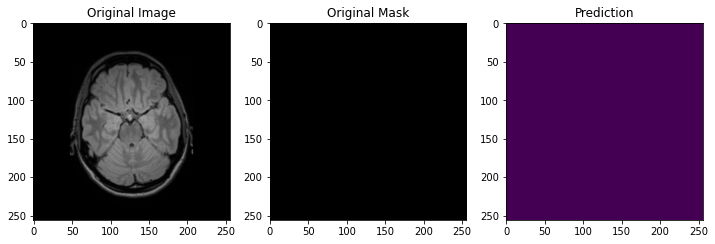

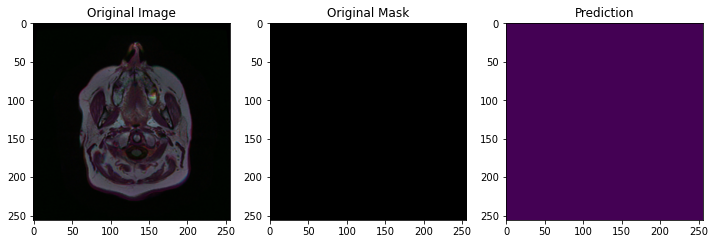

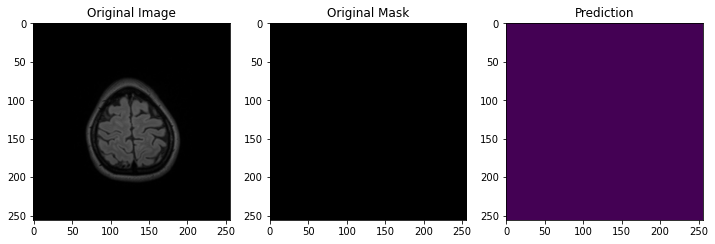

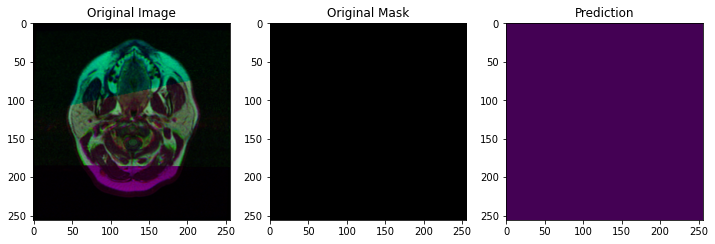

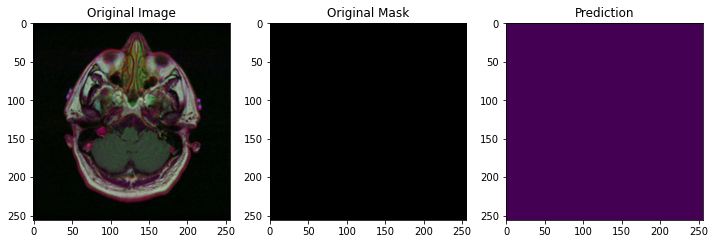

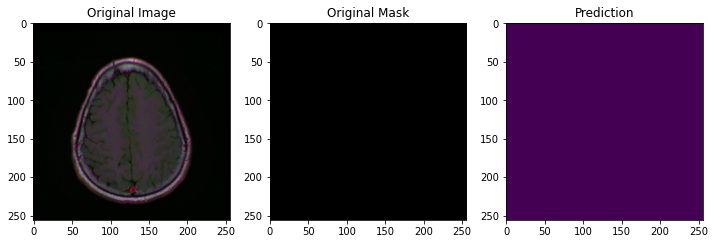

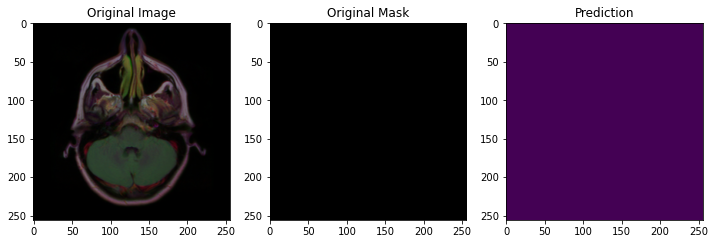

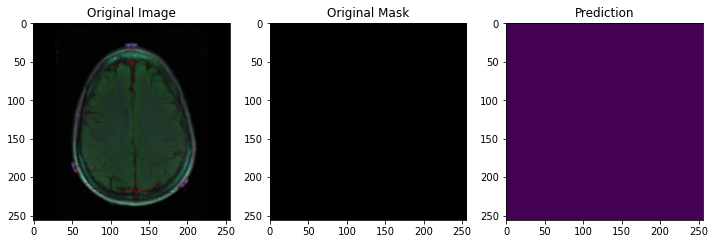

In [ ]:
for i in range(30):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[index])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred= deeplab.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()